## Masked Q-Learning on Maze

In [ ]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

### Experience replay

In [ ]:
# Store experience tuples to retrieve replay data for training later
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        # Maximum number of transitions that cat be stored
        self.capacity = capacity
        # Ensure old data is discarded when new data arrives
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        '''
        Returns the current size of memory buffer
        '''
        return len(self.memory)

    def push(self, transition):
        '''
        Adds a new experience (transition) to the buffer
        '''
        self.memory.append(transition)

    def sample(self, batch_size, device='cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        # Unpack data
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] for idx in indices])
    
        # Convert lists to numpy arrays before creating tensors
        states = np.array(states)
        next_states = np.array(next_states)
    
        # Convert to tensors and move to the correct device
        states = torch.tensor(states, dtype=torch.float).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        isgameon = torch.tensor(isgameon, dtype=torch.bool).to(device)
    
        return states, actions, next_states, rewards, isgameon


### Networks definition
**Fully Connected Neural Network**

In [ ]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        '''
        args:
         - Ni: input size
         - Nh1, Nh2: two hidden layer sizes
         - No: output size
        '''
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        
        # Final layer outputs the Q-values for each action
        out = self.fc3(x)
        
        return out

**Convolutional Neural Network**

In [ ]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64] # Number of feature maps in each convolution layers
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        # Initialize input dimensions (maze size) and number of possible actions (n_act)
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(nn.Linear(size_out_conv, rows*cols*2),
                                    nn.ReLU(),
                                    nn.Linear(rows*cols*2, int(rows*cols/2)),
                                    nn.ReLU(),
                                    nn.Linear(int(rows*cols/2), n_act),
                                   )

    def forward(self, x):
        # Reshape the input to 4D tensor (batch size, channels, height, width)
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        # Flatten output before passing it through linear layers
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        return out_lin
    
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

### Loss Function
**I. Loss Function for State-masking Mechanism**

In [ ]:
def Qloss(batch, net, gamma=0.99, device="cuda"):
    '''
    Computes the Mean Squared Error loss for Q-learning

    args:
     - gamma: discount factor to prioritize near-term rewards
    '''
    states, actions, next_states, rewards, _ = batch

    # Ensure that all tensors are on the correct device
    states = states.to(device)
    next_states = next_states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    
    lbatch = len(states)

    # Flatten the input (states) to match the model's input size
    states = states.view(lbatch, -1)
    next_states = next_states.view(lbatch, -1)

    # Ensure the model is on the correct device
    net.to(device)

    # Forward pass through the model
    # Q-values for current state-action pairs
    state_action_values = net(states) if not USE_MASKED_Q_LEARNING else net(states)
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)

    # Compute maximum predicted Q-values for the next state
    next_state_values = net(next_states)
    next_state_values = next_state_values.max(1)[0]
    next_state_values = next_state_values.detach()

    # Compute target Q-values using Bellman Equation
    expected_state_action_values = next_state_values * gamma + rewards

    # Compute and return the loss
    return nn.MSELoss()(state_action_values, expected_state_action_values)


**II. Loss Function for Invalid Action Masking**

In [ ]:
def Qloss_action(batch, net, gamma, device):
    states, actions, next_states, rewards, _ = batch

    # Compute Q-values for current and next states
    q_vals = net(states)
    next_q_vals = net(next_states)

    # Mask invalid actions
    next_valid_actions = torch.stack([torch.tensor(
        agent.env.get_valid_actions(p)).to(device) for p in agent.env.current_position])
    next_q_vals *= next_valid_actions

    # Compute target Q-values
    max_next_q_vals = torch.max(next_q_vals, dim=1)[0]
    target_q_vals = rewards + gamma * max_next_q_vals

    # Compute loss
    q_vals = q_vals.gather(1, actions.unsqueeze(1)).squeeze()
    
    return F.mse_loss(q_vals, target_q_vals)


### Basic Setting For Training
**Import the maze and define the environment.**

In [ ]:
from environment import MazeEnvironment

# Import the maze
maze = np.load('maze_generator/maze.npy')

# Set initial position and target position
initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

# Define environment
USE_MASKED_Q_LEARNING = True
maze_env = MazeEnvironment(maze, initial_position, goal, masked=USE_MASKED_Q_LEARNING)

# Draw Maze
maze_env.draw('maze_10.pdf')

**Define the buffer and the agent for experience replay.**

In [ ]:
from agent import Agent

# Define the buffer
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

# Define the agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
)

**Define the network and variables.**

In [ ]:
# Use fully connected neural network
net = fc_nn(maze.size, maze.size, maze.size, 4)

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Define device, batch size, gamma
device = 'cuda'
batch_size = 24 # batch_size = 64
gamma = 0.9

# Ensure correct device
net.to(device)

**Define the epsilon profile and plot the resetting probability.**

[1.         0.99004983 0.98019867 0.97044553 0.96078944 0.95122942
 0.94176453 0.93239382 0.92311635 0.91393119 0.90483742 0.89583414
 0.88692044 0.87809543 0.86935824 0.86070798 0.85214379 0.84366482
 0.83527021 0.82695913 0.81873075 0.81058425 0.8025188  0.7945336
 0.78662786 0.77880078 0.77105159 0.76337949 0.75578374 0.74826357
 0.74081822 0.73344696 0.72614904 0.71892373 0.71177032 0.70468809
 0.69767633 0.69073433 0.68386141 0.67705687 0.67032005 0.66365025
 0.65704682 0.65050909 0.64403642 0.63762815 0.63128365 0.62500227
 0.61878339 0.61262639 0.60653066 0.60049558 0.59452055 0.58860497
 0.58274825 0.57694981 0.57120906 0.56552544 0.55989837 0.55432728
 0.54881164 0.54335087 0.53794444 0.5325918  0.52729242 0.52204578
 0.51685133 0.51170858 0.50661699 0.50157607 0.4965853  0.4916442
 0.48675226 0.48190899 0.47711392 0.47236655 0.46766643 0.46301307
 0.45840601 0.4538448  0.44932896 0.44485807 0.44043165 0.43604929
 0.43171052 0.42741493 0.42316208 0.41895155 0.41478291 0.410655

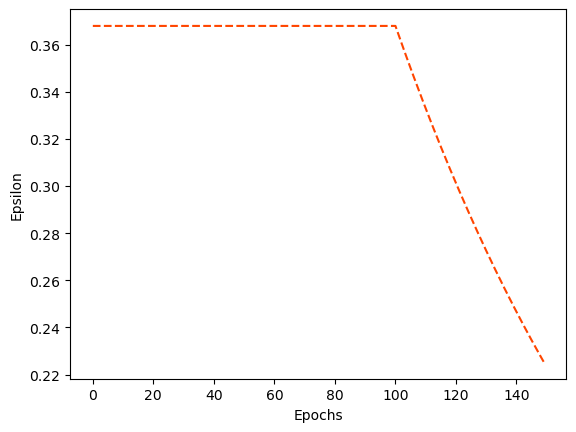

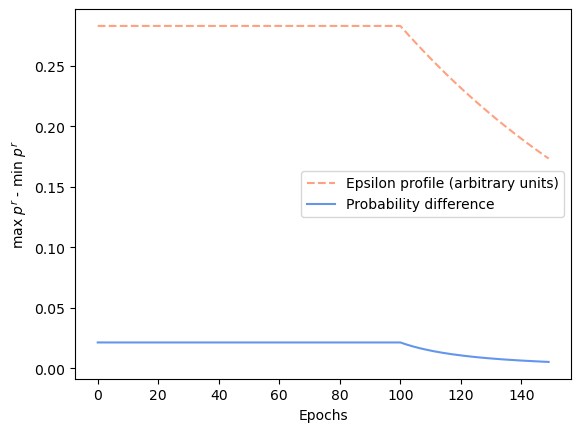

In [ ]:
# Define number of epochs and cutoff value
num_epochs = 150
cutoff = 100

# Decays exponentially over number of epochs to reduce exploration as agent learns more
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
print(epsilon)

# Ensures epsilon does not become too small before sufficient exploration
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]

# Plot epsilon decay
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Tracks max and min probabilities of policy values
mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

### Network Training
**I. Training process for state-masking mechanism**

In [ ]:
# Define variables for loss tracking
loss_log = []
best_loss = 1e5
running_loss = 0

# Ensure all tensors are on the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move to the correct device
net = net.to(device)

for epoch in range(num_epochs):
    net.to(device)
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    # Begin the episode
    agent.isgameon = True

    # Reset environment
    _ = agent.env.reset(eps)
    
    while agent.isgameon:
        net.to(device)
        # Get state and ensure it's on the correct device
        state = agent.get_masked_state(agent.env.current_position) if USE_MASKED_Q_LEARNING else agent.env.state()
        state = torch.tensor(np.array(state), dtype=torch.float).to(device)  # Fix: Convert to ndarray before tensor
        
        # Make the agent perform a move (no device change needed here)
        agent.make_a_move(net, epsilon, state)
        counter += 1
        
        # Wait until the buffer has enough samples
        if len(agent.buffer) < buffer_start_size:
            continue
            
        # Zero the gradients before the backward pass
        optimizer.zero_grad()
        
        # Sample a batch from the buffer and move to the correct device
        batch = agent.buffer.sample(batch_size, device=device)
        states, actions, next_states, rewards, _ = batch
        
        # Ensure all tensors are on the correct device
        states = states.to(device)  # Move states to the correct device
        next_states = next_states.to(device)  # Move next_states to the correct device
        actions = actions.to(device)  # Move actions to the correct device
        rewards = rewards.to(device)  # Move rewards to the correct device
        
        # Compute the loss
        loss_t = Qloss(batch, net, gamma=gamma, device=device)
        loss_t.backward()
        
        # Update the model parameters
        optimizer.step()

        # Add the loss of this batch to the total loss
        loss += loss_t.item()
    
    # Check if the agent has won or lost the game
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'     # Save the policy map every 1000 epochs
    if epoch % 1000 == 0:
        agent.plot_policy_map(net, 'sol_epoch_' + str(epoch) + '.pdf', [0.35, -0.3])
    
    # Log the total loss for this epoch
    loss_log.append(loss)
    
    # Track and save the best model based on the last 50 epochs' average loss
    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")
            estop = epoch
    
    # Print progress and metrics every epoch
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#' * (100 - int(100 * (1 - epoch / num_epochs))) +
          ' ' * int(100 * (1 - epoch / num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if epoch > 2000:
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
    
    # Update output display (if running in Jupyter)
    clear_output(wait=True)

Epoch 149 (number of moves 230)
Game won
[####################################################################################################]
	 Average loss: 0.10144


**II. Training process for invalid action masking algorithm**

In [ ]:
# Define variables for loss tracking
loss_log = []
best_loss = 1e5
running_loss = 0

# Ensure all tensors are on the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move to correct device
net = net.to(device)

for epoch in range(num_epochs):
    net.to(device)
    loss = 0
    counter = 0
    eps = epsilon[epoch] 
    
    # Begin the episode
    agent.isgameon = True
    
    # Reset environment
    _ = agent.env.reset(eps)
    
    while agent.isgameon and counter < 200:  # Add a step limit to avoid infinite loops
        # Get current state
        current_state = agent.env.state()
        current_state_tensor = torch.tensor(np.array(current_state), dtype=torch.float).view(1, -1).to(device)
        
        # Select action with invalid action masking
        action = agent.masked_action_selection(net, current_state_tensor, eps)
        
        # Update next state (perform action)
        next_state, reward, agent.isgameon = agent.env.state_update(action)
        # Update total reward 
        agent.total_reward += reward

        # Store transition
        transition = Transition(current_state, action, next_state, reward, agent.isgameon)
        agent.buffer.push(transition)
        
        counter += 1
        
        # Wait until buffer has enough samples
        if len(agent.buffer) < buffer_start_size:
            continue
        
        # Zero the gradients before the backward pass
        optimizer.zero_grad()
        # Sample a batch from the buffer and move to the correct device
        batch = agent.buffer.sample(batch_size, device=device)
        # Compute the loss
        loss_t = Qloss_action(batch, net, gamma=gamma, device=device)
        loss_t.backward()
        # Update the model parameters
        optimizer.step()
        
        loss += loss_t.item()
    
    # Check if the agent has won or lost the game
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost' 
    
    # Save the policy map every 1000 epochs
    if epoch % 1000 == 0:
        agent.plot_policy_map(net, 'sol_epoch_' + str(epoch) + '.pdf', [0.35, -0.3])
    
    # Log the total loss for this epoch
    loss_log.append(loss)
    
    # Track and save the best model based on the last 50 epochs' average loss
    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")
            estop = epoch
    
    # Print progress and metrics every epoch
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#' * (100 - int(100 * (1 - epoch / num_epochs))) +
          ' ' * int(100 * (1 - epoch / num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if epoch > 2000:
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
    
    # Update output display (if running in Jupyter)
    clear_output(wait=True)

### Results Visualization
**Save weights of training process for future use.**

In [14]:
torch.save(net.state_dict(), "net.torch")

**Create 'loss.pdf': loss over epoch.**

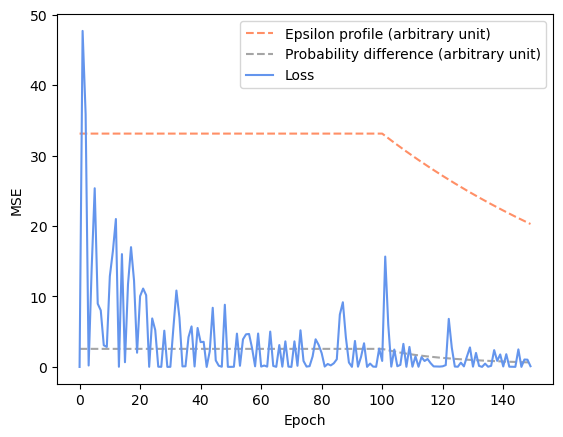

In [15]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig('loss.pdf', dpi = 300, bbox_inches='tight')
plt.show()

**Show the behavior of agents.**

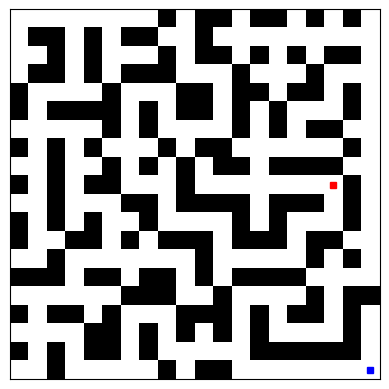

In [16]:
net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(net, 0)
    agent.env.draw('')
    clear_output(wait = True)

**Create 'solution.pdf': shows the maze solution and the policy learnt.**

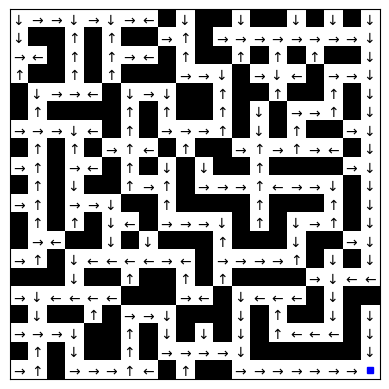

In [17]:
agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])

**Get best solution and creates 'solution_best.pdf'**

In [18]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('net.torch'))

<All keys matched successfully>

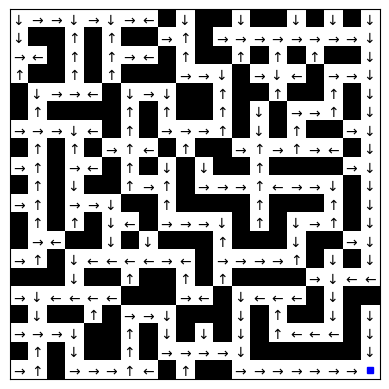

In [19]:
agent.plot_policy_map(best_net, 'solution_best.pdf', [0.35,-0.3])